<a href="https://colab.research.google.com/github/KhashayarJahanbakhsh/car-price-prediction/blob/main/car_predict_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

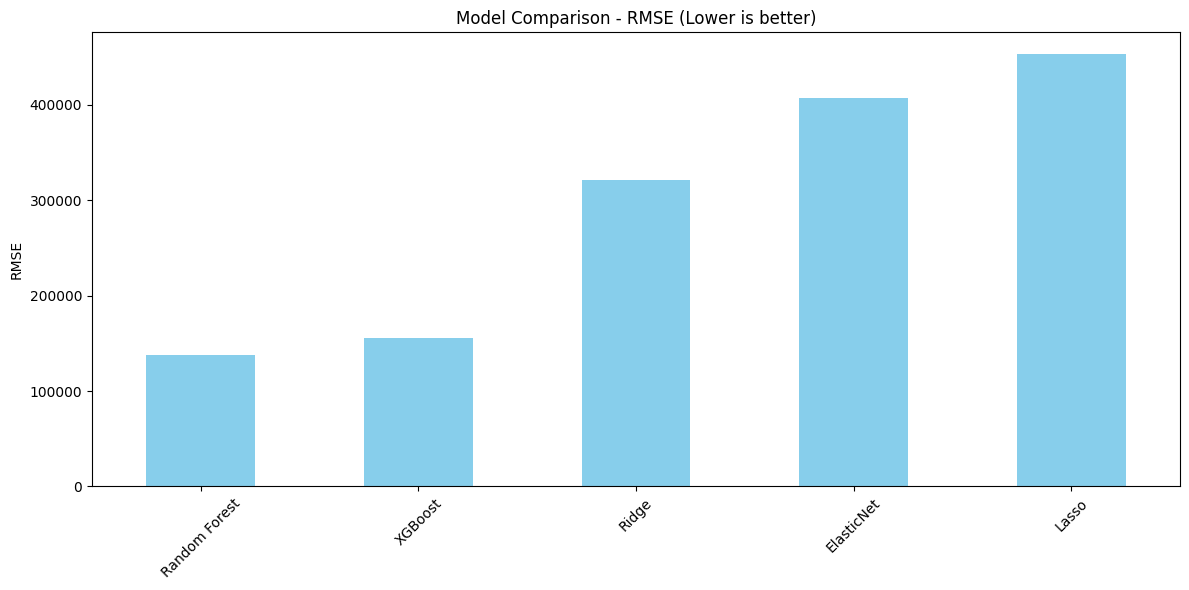

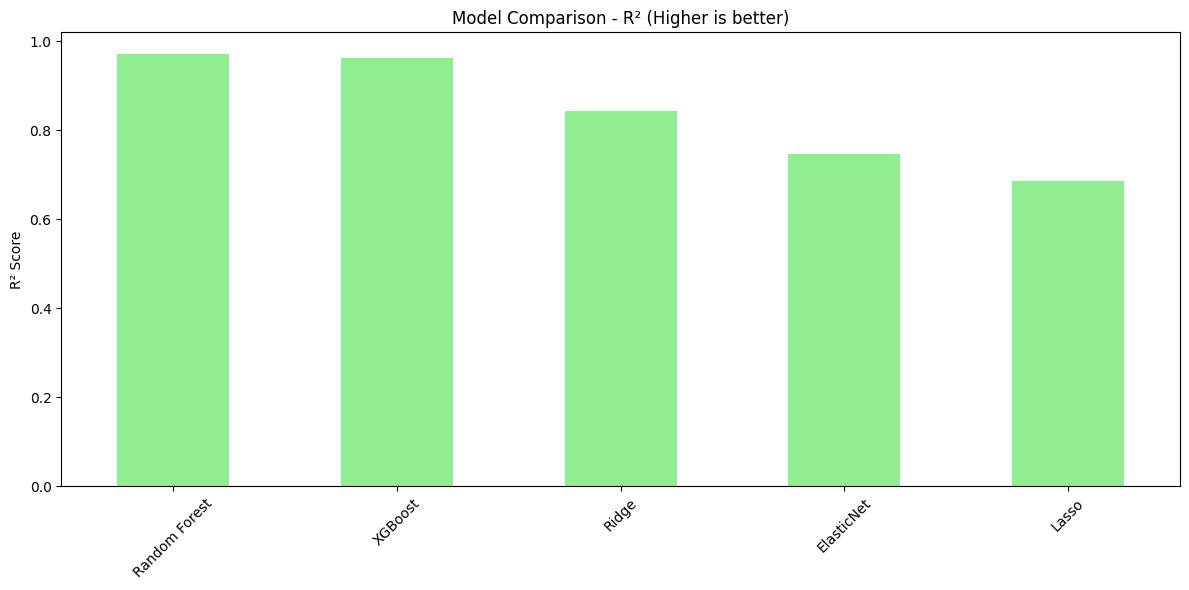


Model Performance Comparison:
                        rmse        r2   cv_rmse
Random Forest  137591.655630  0.971118  0.222865
XGBoost        155900.005389  0.962921  0.218601
Ridge          321616.104961  0.842198  0.310221
ElasticNet     407381.766713  0.746813  0.326951
Lasso          453470.644800  0.686285  0.354066


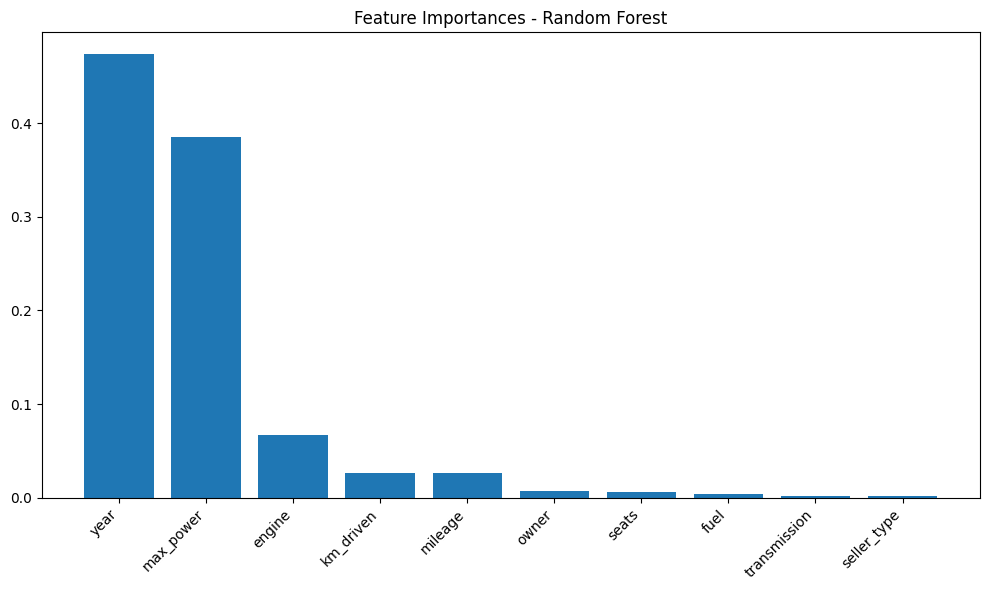

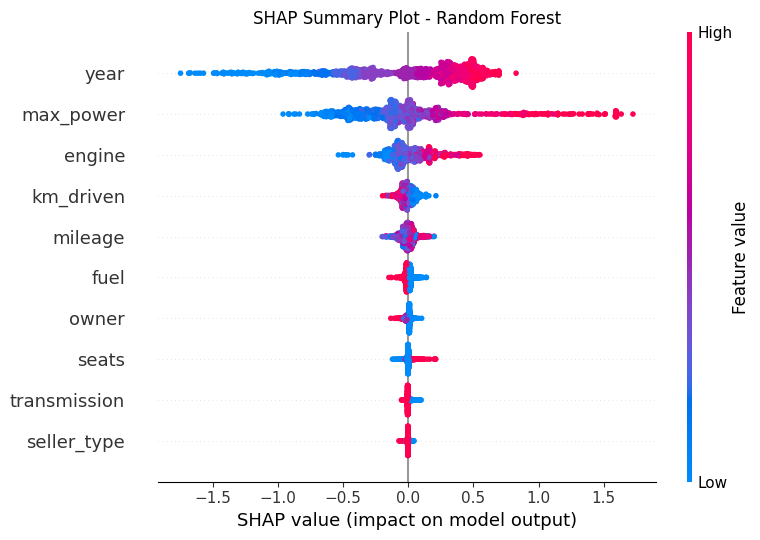

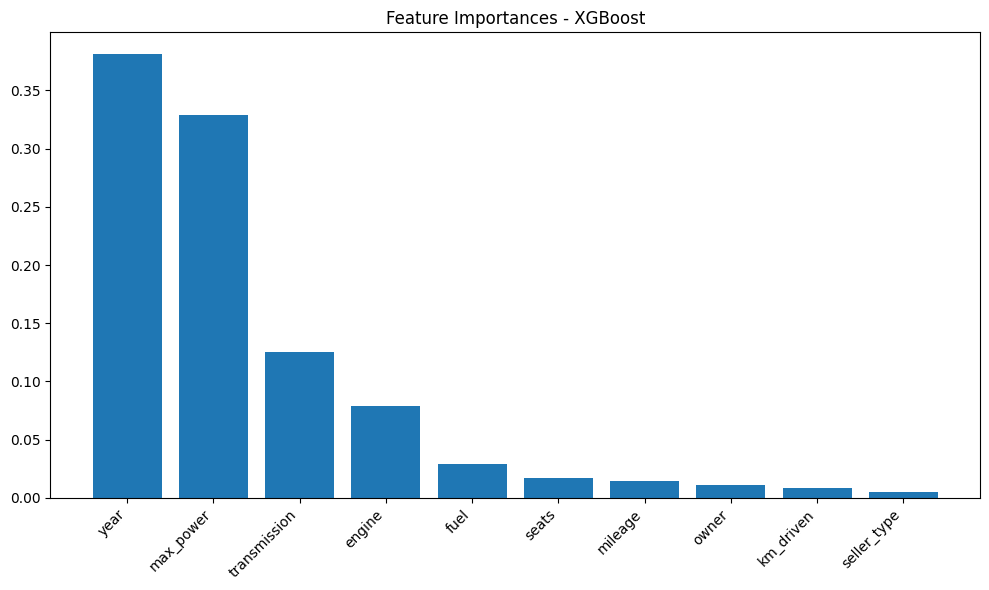

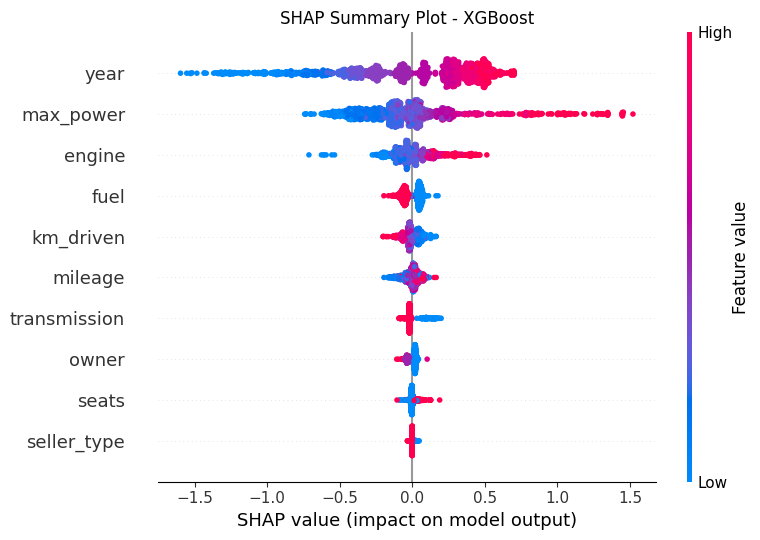

In [5]:
# car_price_comparison.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import logging
from pathlib import Path
import shap
import joblib
import re

# ----------------- Logging Setup -----------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

def clean_numeric_column(series, unit):
    """Helper function to clean numeric columns with units"""
    if series.dtype == 'object':
        # Handle both space and no space between number and unit
        pattern = fr'(\d+\.?\d*)\s*{re.escape(unit)}'
        series = series.str.extract(pattern, expand=False).astype(float)
    return series

def load_and_preprocess(data_path):
    """Load and preprocess the data."""
    logger.info("Loading and preprocessing data...")
    df = pd.read_csv(data_path)

    # Clean numeric columns with units
    df['mileage'] = clean_numeric_column(df['mileage'], 'kmpl')
    df['mileage'] = clean_numeric_column(df['mileage'], 'km/kg')  # For CNG cars
    df['engine'] = clean_numeric_column(df['engine'], 'CC')
    df['max_power'] = clean_numeric_column(df['max_power'], 'bhp')

    # Handle missing values
    numeric_cols = ['mileage', 'engine', 'max_power', 'seats', 'km_driven', 'year']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Encode categorical variables
    categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
    label_encoders = {}
    for col in categorical_columns:
        if col in df.columns:
            label_encoders[col] = LabelEncoder()
            df[col] = label_encoders[col].fit_transform(df[col].astype(str))

    # Log transform target
    if 'selling_price' in df.columns:
        df['log_selling_price'] = np.log1p(df['selling_price'])
        y = df['log_selling_price'].values
    else:
        y = None

    # Prepare features
    feature_columns = [
        'year', 'km_driven', 'fuel', 'seller_type',
        'transmission', 'owner', 'mileage', 'engine',
        'max_power', 'seats'
    ]
    X = df[feature_columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, df, feature_columns, scaler, label_encoders

def plot_shap_summary(model, X, feature_names, title, filename):
    """Plots SHAP summary plot for a given model."""
    try:
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X)

        plt.figure(figsize=(15, 10))
        shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
    except Exception as e:
        logger.error(f"Error in SHAP analysis for {title}: {str(e)}")


class ModelComparison:
    def __init__(self, models):
        self.models = models
        self.results = {}

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        """Train and evaluate all models."""

        for name, model in self.models.items():
            try:
                logger.info(f"Training {name}...")
                model.fit(X_train, y_train)

                # Make predictions
                y_pred = model.predict(X_test)
                y_test_original = np.expm1(y_test)
                y_pred_original = np.expm1(y_pred)

                # Calculate metrics
                mse = mean_squared_error(y_test_original, y_pred_original)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test_original, y_pred_original)

                # Cross-validation
                cv_scores = cross_val_score(
                    model, X_train, y_train,
                    cv=5, scoring='neg_mean_squared_error'
                )
                cv_rmse = np.sqrt(-cv_scores.mean())

                self.results[name] = {
                    'model': model,
                    'rmse': rmse,
                    'r2': r2,
                    'cv_rmse': cv_rmse
                }

                logger.info(f"{name} - RMSE: {rmse:,.2f}, R²: {r2:.4f}, CV RMSE: {cv_rmse:,.2f}")

            except Exception as e:
                logger.error(f"Error training {name}: {str(e)}")
                continue

        return self.results

    def plot_comparison(self):
        """Plot model comparison."""
        if not self.results:
            logger.error("No results to plot. Train models first.")
            return

        metrics = pd.DataFrame.from_dict(self.results, orient='index')
        metrics = metrics[['rmse', 'r2', 'cv_rmse']]

        # Plot RMSE comparison
        plt.figure(figsize=(12, 6))
        metrics['rmse'].sort_values().plot(kind='bar', color='skyblue')
        plt.title('Model Comparison - RMSE (Lower is better)')
        plt.ylabel('RMSE')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_rmse_comparison.png')
        plt.show()

        # Plot R² comparison
        plt.figure(figsize=(12, 6))
        metrics['r2'].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
        plt.title('Model Comparison - R² (Higher is better)')
        plt.ylabel('R² Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_r2_comparison.png')
        plt.show()

        return metrics


# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=150, learning_rate=0.1,
                           max_depth=5, random_state=42)
}

# Load and preprocess data
X_scaled, y, df, feature_columns, scaler, label_encoders = load_and_preprocess('Car details v3.csv')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Initialize and run model comparison
comparator = ModelComparison(models)
results = comparator.train_and_evaluate(X_train, X_test, y_train, y_test)

if not results:
    logger.error("No models were successfully trained.")
else:
    # Display and plot results
    metrics_df = comparator.plot_comparison()
    print("\nModel Performance Comparison:")
    print(metrics_df.sort_values('rmse'))

    # Save the best model
    best_model_name = min(results.items(), key=lambda x: x[1]['rmse'])[0]
    best_model = results[best_model_name]['model']
    joblib.dump(best_model, f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
    logger.info(f"Best model saved as 'best_model_{best_model_name.lower().replace(" ", "_")}.pkl'")

    # Analyze feature importance for tree-based models and SHAP
    for name, model_info in results.items():
        model = model_info['model']
        if isinstance(model, (RandomForestRegressor, XGBRegressor)):
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]

                plt.figure(figsize=(10, 6))
                plt.title(f'Feature Importances - {name}')
                plt.bar(range(len(importances)), importances[indices])
                plt.xticks(range(len(importances)),
                          [feature_columns[i] for i in indices],
                          rotation=45, ha='right')
                plt.tight_layout()
                plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
                plt.show()

            # SHAP analysis
            plot_shap_summary(model, X_test, feature_columns,
                              f"SHAP Summary Plot - {name}",
                              f"shap_summary_{name.lower().replace(" ", "_")}.png")